In [16]:
library(dplyr)
library(tidyr)
library(tibble)
library(ggplot2)
library(stringr)
library(ggrepel)
library(ggh4x)
library(grid)
library("cowplot")
library(patchwork)
is_dark_color <- function(hex) {
  rgb <- col2rgb(hex)
  
  luminance <- 0.299 * rgb[1,] + 0.587 * rgb[2,] + 0.114 * rgb[3,]
  if(luminance < 128){
  return('white')
  }else{return('black')}
}


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




In [9]:
color_annotation<-read.csv('../Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_vector <- setNames(color_annotation$color, color_annotation$label)

In [10]:
df<-read.csv('02_Freq_Changes_Y1D0/Freq_OverTime_CMVpos.csv')

In [11]:
df <- df %>% dplyr::mutate(`Age Group` = case_when(
  cohort.cohortGuid == "BR1" ~ "Young",
  cohort.cohortGuid == "BR2" ~ "Older",
  TRUE ~ NA_character_
))
df$`Age Group`<-factor(df$`Age Group`,levels=c("Young","Older"))

In [12]:
options(repr.plot.width = 50/25.4, repr.plot.height = 70/25.4)

p <- ggplot(df, 
            aes(sample.daysSinceFirstVisit, AIFI_L3_clr,color=`Age Group`)) +
    geom_point(size = 0.75,  stroke = 0) +
    geom_smooth(method="lm",se=FALSE, linewidth=0.2) + 
scale_color_manual(values = c("Older"='#bf812d',  "Young"='#35978f'))+
    theme_bw(base_size = 6) +
    theme(axis.line = element_line(colour = "black", linewidth = 0.1),
          legend.position = "top",
          legend.title = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border = element_blank(),
          panel.background = element_blank(),
          strip.background = element_rect(linewidth = 0),
          axis.title.x = element_text(margin = margin(t = 2))) +
    facet_wrap2(~AIFI_L3, axes = "all", remove_labels = "all", ncol=1, scale='free_y')  + theme(
    panel.spacing = unit(-0.4,'lines')
  )


In [13]:
celltype_order<-c('Adaptive NK cell',
  'KLRF1- effector Vd1 gdT',
'KLRF1- GZMB+ CD27- EM CD8 T cell',
'KLRF1- GZMB+ CD27- memory CD4 T cell')

In [34]:
plot_list<-list()
for (selected_celltype in celltype_order){
df_sub <- df %>% filter(AIFI_L3 == selected_celltype)

p1 <- ggplot(df_sub, aes(sample.daysSinceFirstVisit, AIFI_L3_clr, color = `Age Group`)) +
geom_line(aes(group = interaction(`Age Group`, subject.subjectGuid)), 
              linewidth=0.1, 
              alpha=0.4,
              linetype =1)+
  ylab('') +
  theme_bw(base_size = 8) +
  theme(
    axis.line = element_line(colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank()
  ) + 
  scale_color_manual(values = c("Older" = '#bf812d', "Young" = '#35978f')) +
  geom_smooth(method = "lm", se = TRUE, linewidth = 0.3) +
  facet_wrap2(~AIFI_L3, axes = "all", remove_labels = "all", ncol = 1, scale = 'free_y') +
  theme(
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    strip.background = element_rect(fill = adjustcolor(color_vector[selected_celltype], alpha.f = 0.8), color = NA),
    strip.text = element_text(color = is_dark_color(adjustcolor(color_vector[selected_celltype], alpha.f = 0.8)))
  ) +
  xlab('') +
  theme(legend.position = "none")

p2 <- ggplot(df_sub, aes(AIFI_L3_clr, fill = `Age Group`, color = `Age Group`)) +
  geom_density(alpha = 0.5, linewidth = 0.5) +
  scale_fill_manual(values = c("Older" = '#bf812d', "Young" = '#35978f')) +
  scale_color_manual(values = c("Older" = '#bf812d', "Young" = '#35978f')) +
  coord_flip() +
  theme_void(base_size = 8) +
  theme(legend.position = "none") +
  theme(plot.margin = margin(0, 0, 0, -1, "mm"))

combined_plot <- plot_grid(p1, p2, ncol = 2, rel_widths = c(10, 0.4), align = 'h', axis = 'tb')
plot_list[[selected_celltype]]<-combined_plot
}


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


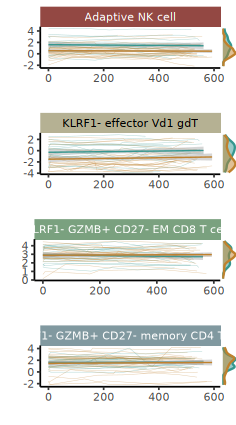

In [37]:
options(repr.plot.width = 50/25.4, repr.plot.height = 90/25.4)

p<-plot_grid(plot_list[[1]],plot_list[[2]], plot_list[[3]], plot_list[[4]], 
             ncol = 1, rel_widths = c(10, 10), align = 'h', axis = 'tb')
p
ggsave('FigureB.pdf',p,width = 50/25.4,height = 90/25.4)

`geom_smooth()` using formula = 'y ~ x'


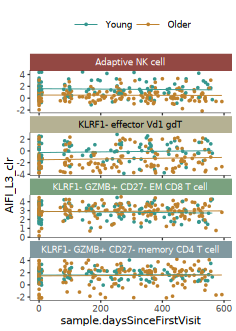

In [7]:
celltype_order<-c('Adaptive NK cell',
  'KLRF1- effector Vd1 gdT',
'KLRF1- GZMB+ CD27- EM CD8 T cell',
'KLRF1- GZMB+ CD27- memory CD4 T cell')
plot <- ggplot_gtable(ggplot_build(p))

strips <- which(grepl('strip-', plot$layout$name))

pal <- color_vector[celltype_order]
text_color <- sapply(color_vector[celltype_order], is_dark_color)

for (i in seq_along(strips)) {
  k <- which(grepl('rect', plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  l <- which(grepl('titleGrob', plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[k]]$gp$fill <- adjustcolor(pal[i], alpha.f = 0.8)
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[l]]$children[[1]]$gp$col <- text_color[i]
}

plot(plot)
ggsave('FigureB.pdf',plot,width = 50/25.4,height = 70/25.4)